# 멋진 챗봇 만들기

## 1. 데이터 다운로드

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import re
import os
import io
import time
import random

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.4.1


In [2]:
data_dir = os.getenv('HOME')+'/aiffel/GoingDeeper/Project06/ChatbotData.csv'

with open(data_dir, "r") as f:
    corpus = f.read().splitlines()
    
questions=[]
answers=[]
for sen in corpus :
    spl = sen.split(sep=',')
    questions.append(spl[0])
    answers.append(spl[1])

# able은 일단 쓰지 않는다
# 첫번째 원소는 데이터 이름이므로 빼준다
questions = questions[1:]
answers = answers[1:]

## 2. 데이터 정제, 토큰화

In [3]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()

    #sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    #sentence = re.sub(r'[" "]+', " ", sentence)
    #숫자도 포함한다
    sentence = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ0-9?.!,]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence

In [4]:
from konlpy.tag import Mecab

#1. 소스 문장 데이터와 타겟 데이터를 입력으로 받는다.
def build_corpus(questions, answers):
    #2. preprocess_sentence를 이용 데이터를 정제한다.
    pre_questions = []
    for sen in questions :
        pre_questions.append(preprocess_sentence(sen))
    pre_answers = []
    for sen in answers :
        pre_answers.append(preprocess_sentence(sen))
    #3. mecab.morph를 이용 토큰화한다.
    mecab = Mecab()
    que_corpus = []
    for sen in pre_questions :
        que_corpus.append(mecab.morphs(sen))
    ans_corpus = []
    for sen in pre_answers :
        ans_corpus.append(mecab.morphs(sen))
    #4. 토큰의 길이가 일정 길이 이상이면 데이터에서 제외한다.
    
    return que_corpus, ans_corpus

In [5]:
que_corpus, ans_corpus =build_corpus(questions, answers)


In [6]:
print("que_corpus 데이터 개수 :{}".format(len(que_corpus)))
print("que_corpus 첫번째 데이터 :{}".format(que_corpus[0]))
print("ans_corpus 데이터 개수 :{}".format(len(ans_corpus)))
print("ans_corpus 첫번째 데이터 :{}".format(ans_corpus[0]))

que_corpus 데이터 개수 :11823
que_corpus 첫번째 데이터 :['12', '시', '땡', '!']
ans_corpus 데이터 개수 :11823
ans_corpus 첫번째 데이터 :['하루', '가', '또', '가', '네요', '.']


문장길이가 아니라 토큰길이로 일정토큰수 이상은 잘라야하는데 build_corpus에서 패딩을 벌써 해버렸네...  
패딩하기전에 토큰길이의 분포를 구하고 그이상은 자르고 패딩해야할듯

4
문장길이 평균 :  7.008542671064873
문장길이 최대 :  32
문장길이 최소 :  1
문장길이 표준편차 :  3.516254797977332
pad_sequences maxlen :  14
전체 문장의 0.9589782627082805%가 maxlen 설정값 이내에 포함됩니다. 
sentence_length :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


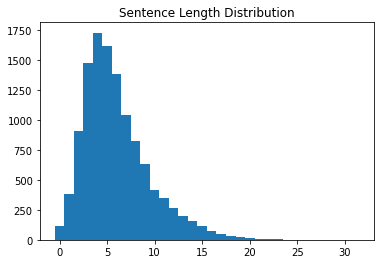

In [7]:

import matplotlib.pyplot as plt

min_len = 999
max_len = 0
sum_len = 0

for token in que_corpus:
    length = len(token)
    
    # 문장 최소 길이 찾기
    if min_len > length: 
        min_len = length
    
    # 문장 최대 길이 찾기
    if max_len < length: 
        max_len = length
        
    sum_len += length

num_sentences = [len(sentence) for sentence in que_corpus]
print(num_sentences[0])
num_sentences = np.array(num_sentences)

print('문장길이 평균 : ', np.mean(num_sentences))
print('문장길이 최대 : ', np.max(num_sentences))
print('문장길이 최소 : ', np.min(num_sentences))
print('문장길이 표준편차 : ', np.std(num_sentences))

#평균 + 표준편차*2
max_sentence = np.mean(num_sentences) + 2 * np.std(num_sentences)
maxlen = int(max_sentence)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_sentences < max_sentence) / len(num_sentences)))

sentence_length = np.zeros((max_len), dtype=np.int)
print("sentence_length : ",sentence_length)

for sen in que_corpus:
    sentence_length[len(sen)-1] += 1 

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

토큰이 15개를 초과하는 데이터는 제거  
데이터 쌍을 유지하기 위해 인덱스를 이용 타겟 데이터도 같이 제거해준다.

In [8]:
q_corpus = []
a_corpus = []
#que_corpus의 길이가 15미만인것만 넣어줌, 데이터 쌍을 유지하기 위해 a_corpus에도 넣어줌
for idx in range(len(que_corpus)) :
    if len(que_corpus[idx]) <15 :
        q_corpus.append(que_corpus[idx])
        a_corpus.append(ans_corpus[idx])
                        
#a_corpus에서 길이 15미만인 데이터를 제거함, 데이터 쌍을 유지하기 위해 q_corpus에도 같은 작업        
for idx in range(len(a_corpus)) :
    if len(a_corpus[idx]) >15 :
        a_corpus[idx] = 0
        q_corpus[idx] = 0

while 0 in a_corpus :
    a_corpus.remove(0)

while 0 in q_corpus :
    q_corpus.remove(0)

print("a_corpus의 데이터 수",len(a_corpus))
print("q_corpus의 데이터 수",len(q_corpus))

a_corpus의 데이터 수 10909
q_corpus의 데이터 수 10909


## 3. 데이터 Augmentation

In [9]:
import gensim

file_path = os.getenv('HOME')+'/aiffel/GoingDeeper/Project06/ko.bin'
ko_model = gensim.models.Word2Vec.load(file_path)
a = ko_model.wv.most_similar("강아지")

print(a)

[('고양이', 0.7290452718734741), ('거위', 0.7185635566711426), ('토끼', 0.7056223154067993), ('멧돼지', 0.6950401067733765), ('엄마', 0.6934334635734558), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.6750352382659912), ('아빠', 0.6729634404182434), ('목걸이', 0.6512460708618164)]


In [10]:
def lexical_sub(toks, word2vec):
    import random
    
    #res = ""
    #toks = sentence.split()
    new_list = []

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: new_list.append(_to)
        else: new_list.append(tok)
        #if tok is _from: res += _to + " "
        #else: res += tok + " "

    return new_list

In [11]:
mecab = Mecab()
morph = [" ".join(mecab.morphs(sen)) for sen in questions]
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words = 50000, oov_token="<UNK>")
tokenizer.fit_on_texts(morph)

In [12]:
type(ko_model)

gensim.models.word2vec.Word2Vec

In [13]:
ko_model.most_similar("바다")[0][0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


'육지'

In [14]:
from tqdm import tqdm_notebook

new_corpus = []

for idx in tqdm_notebook(range(3000)):
    old_src = a_corpus[idx]
    
    new_src = lexical_sub(old_src, ko_model)
    #print(new_src)

    if new_src is not None: new_corpus.append(new_src)

    new_corpus.append(old_src)
    #print(old_src)

print(new_corpus[:10])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


[['하루', '가', '각기', '가', '네요', '.'], ['하루', '가', '또', '가', '네요', '.'], ['위로', '해', '드립니다', '는데'], ['위로', '해', '드립니다', '.'], ['항해', '은', '언제나', '좋', '죠', '.'], ['여행', '은', '언제나', '좋', '죠', '.'], ['여행', '은', '언제나', '괜찮', '죠', '.'], ['여행', '은', '언제나', '좋', '죠', '.'], ['눈살', '이', '찌푸려', '지', '지요', '.'], ['눈살', '이', '찌푸려', '지', '죠', '.']]


잘 작동하는것 같습니다, 이제 데이터를 불려 봅시다

In [15]:
from tqdm import tqdm_notebook

aug_question = list(q_corpus)
aug_answer = list(a_corpus)
print("aug_question 데이터 수",len(aug_question))
print("aug_answer 데이터 수",len(aug_answer))

#aug 질문 추가
for idx in tqdm_notebook(range(len(q_corpus))):
    old_que = q_corpus[idx]
    
    new_que = lexical_sub(old_que, ko_model)

    if new_que is not None: 
        aug_question.append(new_que)
        aug_answer.append(a_corpus[idx])

#aug 답변 추가
for idx in tqdm_notebook(range(len(q_corpus))):
    old_ans = a_corpus[idx]
    
    new_ans = lexical_sub(old_ans, ko_model)

    if new_ans is not None: 
        aug_answer.append(new_ans)
        aug_question.append(q_corpus[idx])
        
print("aug_question 데이터 수",len(aug_question))
print("aug_answer 데이터 수",len(aug_answer))

aug_question 데이터 수 10909
aug_answer 데이터 수 10909


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/10909 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10909 [00:00<?, ?it/s]

aug_question 데이터 수 29643
aug_answer 데이터 수 29643


In [16]:
print(aug_question[15000:15005])
print(aug_answer[15000:15005])

[['핸드폰', '중독', '허가', '봐'], ['휴대폰', '중독', '인', '듯'], ['핸드폰', '적재', '해야지'], ['핸드폰', '패턴', '궁금', '해의'], ['휴대폰', '게임', '자꾸', '하', '게', '돼']]
[['가끔', '핸드폰', '없이', '살', '아', '보', '세요', '.'], ['중독', '에서', '벗어나', '세요', '.'], ['충전기', '를', '찾아보', '세요', '.'], ['할', '수', '있', '다면요', '.'], ['시간', '을', '정해', '보', '세요', '.']]


In [17]:
print(aug_question[25000:25005])
print(aug_answer[25000:25005])

[['끝', '까지', '참', '못난', '놈', '!'], ['끝', '까지', '함께', '할', '거', '라', '믿', '었', '는데'], ['끝', '나', '지', '않', '을까', '봐', '겁', '이나'], ['끝', '날', '때', '까지', '끝난', '게', '아니', '라지만'], ['끝', '내', '는', '게', '맞', '을까']]
[['사랑', '앞', '에선', '진실', '된', '모습', '이', '괜찮', '아요', '.'], ['사랑', '이에', '는', '유통', '기한', '이', '있', '나', '봐요', '.'], ['끝', '을', '지날', '수', '있', '를', '거', '예요', '.'], ['끝', '이', '보여주', '고', '있', '나요', '.'], ['고민', '하', '고', '있', '다면', '그게', '들어맞', '을', '거', '예요', '.']]


데이터의 병렬쌍은 잘 유지되어 있습니다, 다만 augmentation의 결과가 좀 의심스럽네요...

## 4. 데이터 벡터화

word_to_index/ index_to_word 함수 만들어서 벡터화  
전체 데이터 단어 사전 구축하기  
데이터 패딩하기  
트랜스포머 모델로 학습하기  
BLEU로 모델 평가하기  

In [18]:
#단어사전 만들기
from collections import Counter

vocab_size = 10000

words = np.concatenate(aug_question + aug_answer).tolist()
counter = Counter(words)
counter = counter.most_common(vocab_size-4)
vocab = ['', '', '', ''] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
word_to_index


{'': 3,
 '.': 4,
 '이': 5,
 '하': 6,
 '는': 7,
 '세요': 8,
 '을': 9,
 '가': 10,
 '어': 11,
 '고': 12,
 '거': 13,
 '보': 14,
 '해': 15,
 '좋': 16,
 '있': 17,
 '은': 18,
 '지': 19,
 '나': 20,
 '?': 21,
 '도': 22,
 '아': 23,
 '게': 24,
 '겠': 25,
 '는데': 26,
 '에': 27,
 '예요': 28,
 '사람': 29,
 '어요': 30,
 '다': 31,
 '를': 32,
 '죠': 33,
 '같': 34,
 '싶': 35,
 '네요': 36,
 '한': 37,
 '사랑': 38,
 '없': 39,
 '네': 40,
 '안': 41,
 '면': 42,
 '수': 43,
 '것': 44,
 '봐요': 45,
 '친구': 46,
 '잘': 47,
 '의': 48,
 '아요': 49,
 '생각': 50,
 '마음': 51,
 '할': 52,
 '너무': 53,
 '말': 54,
 '않': 55,
 '되': 56,
 '주': 57,
 '했': 58,
 '일': 59,
 '더': 60,
 '만': 61,
 '기': 62,
 '었': 63,
 '이별': 64,
 '내': 65,
 '들': 66,
 '연락': 67,
 '많이': 68,
 '힘들': 69,
 '남자': 70,
 '해요': 71,
 '여자': 72,
 '시간': 73,
 '길': 74,
 '먹': 75,
 '으면': 76,
 '에요': 77,
 '저': 78,
 '!': 79,
 '괜찮': 80,
 '좀': 81,
 '때': 82,
 '많': 83,
 '았': 84,
 '야': 85,
 '으로': 86,
 '남': 87,
 '썸': 88,
 '에서': 89,
 '한테': 90,
 '요': 91,
 '받': 92,
 '마세요': 93,
 '오늘': 94,
 '뭐': 95,
 '그러': 96,
 '짝': 97,
 '만나': 98,
 '적': 99,
 '건': 

In [19]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{3: '',
 4: '.',
 5: '이',
 6: '하',
 7: '는',
 8: '세요',
 9: '을',
 10: '가',
 11: '어',
 12: '고',
 13: '거',
 14: '보',
 15: '해',
 16: '좋',
 17: '있',
 18: '은',
 19: '지',
 20: '나',
 21: '?',
 22: '도',
 23: '아',
 24: '게',
 25: '겠',
 26: '는데',
 27: '에',
 28: '예요',
 29: '사람',
 30: '어요',
 31: '다',
 32: '를',
 33: '죠',
 34: '같',
 35: '싶',
 36: '네요',
 37: '한',
 38: '사랑',
 39: '없',
 40: '네',
 41: '안',
 42: '면',
 43: '수',
 44: '것',
 45: '봐요',
 46: '친구',
 47: '잘',
 48: '의',
 49: '아요',
 50: '생각',
 51: '마음',
 52: '할',
 53: '너무',
 54: '말',
 55: '않',
 56: '되',
 57: '주',
 58: '했',
 59: '일',
 60: '더',
 61: '만',
 62: '기',
 63: '었',
 64: '이별',
 65: '내',
 66: '들',
 67: '연락',
 68: '많이',
 69: '힘들',
 70: '남자',
 71: '해요',
 72: '여자',
 73: '시간',
 74: '길',
 75: '먹',
 76: '으면',
 77: '에요',
 78: '저',
 79: '!',
 80: '괜찮',
 81: '좀',
 82: '때',
 83: '많',
 84: '았',
 85: '야',
 86: '으로',
 87: '남',
 88: '썸',
 89: '에서',
 90: '한테',
 91: '요',
 92: '받',
 93: '마세요',
 94: '오늘',
 95: '뭐',
 96: '그러',
 97: '짝',
 98: '만나',
 99: '적',
 100: 

In [20]:

#word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<pad>"] = 0
word_to_index["<start>"] = 1
word_to_index["<end>"] = 2  # unknown
word_to_index["<unk>"] = 3

index_to_word[0] = "<pad>"
index_to_word[1] = "<start>"
index_to_word[2] = "<end>"
index_to_word[3] = "<unk>"

In [21]:
for idx in range(len(aug_answer)):
    aug_answer[idx] = ["<start>"] + aug_answer[idx] + ["<end>"]

In [22]:
aug_answer[:10]

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'],
 ['<start>', '위로', '해', '드립니다', '.', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>'],
 ['<start>', '눈살', '이', '찌푸려', '지', '죠', '.', '<end>'],
 ['<start>', '다시', '새로', '사', '는', '게', '마음', '편해요', '.', '<end>'],
 ['<start>', '다시', '새로', '사', '는', '게', '마음', '편해요', '.', '<end>'],
 ['<start>', '잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.', '<end>'],
 ['<start>', '시간', '을', '정하', '고', '해', '보', '세요', '.', '<end>'],
 ['<start>', '시간', '을', '정하', '고', '해', '보', '세요', '.', '<end>']]

In [23]:
word_to_index["시"]

174

In [24]:
def word_to_vector(token, word_to_index) :
    if token in word_to_index :
        return word_to_index[token]
    return word_to_index["<unk>"]

def vector_to_word(token, index_to_word) :
    if token in index_to_word :
        return index_to_word[token]
    return index_to_word[3]

def word_to_vectors(tokens, word_to_index) :
    corpus = []
    for token in tokens :
        corpus.append(word_to_vector(token,word_to_index))
    return corpus

def vector_to_words(tokens, index_to_word) :
    corpus = []
    for token in tokens :
        corpus.append(vector_to_word(token,index_to_word))
    return corpus


In [25]:
src_corpus = []

for tokens in aug_question:
    src_corpus.append(word_to_vectors(tokens,word_to_index))
    
src_corpus

[[2439, 174, 3360, 79],
 [295, 3900, 505, 925, 11],
 [320, 2263, 597, 59, 211, 238, 10, 12, 35, 31],
 [320, 2263, 597, 59, 480, 211, 238, 10, 12, 35, 31],
 [4762, 1027, 40],
 [3901, 1336, 6152, 11],
 [3901, 1336, 41, 139],
 [756, 208, 1151, 116, 41, 6, 19, 860],
 [756, 73, 2044, 110, 13, 23, 26, 371, 6, 7, 157],
 [756, 73, 2044, 152, 198, 14, 24, 963],
 [756, 14, 42, 20, 61, 1176, 12, 31, 185, 15, 586],
 [468, 311, 15],
 [468, 95, 6, 214, 311, 15],
 [468, 18, 125, 110, 24, 16, 31],
 [4431, 37, 209, 48, 4763],
 [4764, 17, 254, 1297, 1874],
 [6153, 6154, 6155, 2604],
 [2158, 1152, 1787, 12, 1459, 11],
 [2158, 1152, 1787, 438, 12, 1406, 13, 34, 23],
 [2158, 307, 53, 68, 695, 31, 4],
 [2158, 307, 4765, 540, 1298, 25, 11],
 [2158, 307, 964, 2264],
 [506, 249, 10, 62, 101, 58, 11],
 [506, 249, 2265],
 [506, 249, 266, 101, 10, 19, 21],
 [506, 17, 11, 21],
 [506, 442, 1028, 261],
 [506, 2159, 249, 727, 4],
 [506, 66, 14, 12, 35, 11],
 [506, 66, 196, 4432, 15],
 [506, 66, 196, 4432, 717, 11],
 

In [26]:
trans_corpus = []

for tokens in src_corpus:
    trans_corpus.append(vector_to_words(tokens,index_to_word))
    
trans_corpus

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네'],
 ['sd', '카드', '망가졌', '어'],
 ['sd', '카드', '안', '돼'],
 ['sns', '맞', '팔', '왜', '안', '하', '지', 'ㅠㅠ'],
 ['sns', '시간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'],
 ['sns', '시간', '낭비', '인데', '자꾸', '보', '게', '됨'],
 ['sns', '보', '면', '나', '만', '빼', '고', '다', '행복', '해', '보여'],
 ['가끔', '궁금', '해'],
 ['가끔', '뭐', '하', '는지', '궁금', '해'],
 ['가끔', '은', '혼자', '인', '게', '좋', '다'],
 ['가난', '한', '자', '의', '설움'],
 ['가만', '있', '어도', '땀', '난다'],
 ['가상', '화폐', '쫄딱', '망함'],
 ['가스', '불', '켜', '고', '나갔', '어'],
 ['가스', '불', '켜', '놓', '고', '나온', '거', '같', '아'],
 ['가스', '비', '너무', '많이', '나왔', '다', '.'],
 ['가스', '비', '비싼데', '감기', '걸리', '겠', '어'],
 ['가스', '비', '장난', '아님'],
 ['가족', '여행', '가', '기', '로', '했', '어'],
 ['가족', '여행', '고고'],
 ['가족', '여행', '어디', '로', '가', '지', '?'],
 ['가족', '있', '어', '?'],
 ['가족', '관계', '알려', '줘'],
 ['가족'

변환이 정상적으로 되는 모습입니다.

In [27]:
tgt_corpus = []

for tokens in aug_answer:
    tgt_corpus.append(word_to_vectors(tokens,word_to_index))
    
tgt_corpus

[[1, 282, 10, 140, 10, 36, 4, 2],
 [1, 523, 15, 1443, 4, 2],
 [1, 249, 18, 679, 16, 33, 4, 2],
 [1, 249, 18, 679, 16, 33, 4, 2],
 [1, 4668, 5, 4669, 19, 33, 4, 2],
 [1, 133, 1415, 150, 7, 24, 51, 4245, 4, 2],
 [1, 133, 1415, 150, 7, 24, 51, 4245, 4, 2],
 [1, 47, 127, 12, 17, 9, 43, 22, 17, 30, 4, 2],
 [1, 73, 9, 2906, 12, 15, 14, 8, 4, 2],
 [1, 73, 9, 2906, 12, 15, 14, 8, 4, 2],
 [1, 3235, 6, 7, 1017, 271, 4, 2],
 [1, 107, 29, 22, 221, 13, 28, 4, 2],
 [1, 107, 29, 22, 221, 13, 28, 4, 2],
 [1, 125, 32, 688, 8, 4, 2],
 [1, 234, 18, 133, 2573, 13, 28, 4, 2],
 [1, 1297, 9, 3126, 57, 8, 4, 2],
 [1, 119, 138, 12, 470, 1390, 6, 8, 4, 2],
 [1, 469, 180, 27, 793, 136, 1209, 12, 644, 8, 4, 2],
 [1, 469, 180, 27, 793, 136, 1209, 12, 644, 8, 4, 2],
 [1, 383, 131, 27, 7, 60, 1286, 15, 45, 4, 2],
 [1, 543, 6, 24, 557, 79, 2],
 [1, 383, 131, 27, 7, 60, 1286, 15, 45, 4, 2],
 [1, 1190, 506, 5, 500, 51, 27, 333, 7, 237, 86, 10, 14, 8, 4, 2],
 [1, 1190, 506, 5, 500, 51, 27, 333, 7, 237, 86, 10, 14, 8, 4,

In [28]:
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.01)

print("enc_train :", len(enc_train), "enc_val :", len(enc_val))
print("dec_train :", len(dec_train), "dec_val :",len(dec_val))

enc_train : 29346 enc_val : 297
dec_train : 29346 dec_val : 297


In [29]:
len(enc_train[0])

14

토큰이 15개 초과인 데이터를 제거해줬으므로 15 + start 토큰 + end 토큰 총 17개의 토큰

## 5.트랜스포머 구현

In [30]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [31]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [33]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [37]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [38]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [39]:
VOCAB_SIZE = len(word_to_index)

transformer = Transformer(
    n_layers=2,
    d_model=128,
    n_heads=8,
    d_ff=128,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.5,
    shared_fc=True,
    shared_emb=True)
		
d_model = 128

## 6. 모델 학습

In [40]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [41]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [43]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [44]:
mecab = Mecab()
mecab.morphs("지루하다, 놀러가고 싶어.")

['지루', '하', '다', ',', '놀', '러', '가', '고', '싶', '어', '.']

In [45]:
def evaluate(sentence, model, tokenizer):
    mecab = Mecab()
    sentence = preprocess_sentence(sentence)    

    pieces = mecab.morphs(sentence)
    tokens = word_to_vectors(pieces, word_to_index)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    ids = []
    output = tf.expand_dims([word_to_index["<start>"]], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if word_to_index["<end>"] == predicted_id:
            result = vector_to_words(ids, index_to_word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
        

    result = vector_to_words(ids, index_to_word)
    #result = tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [46]:
def translate(sentence, model, tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [47]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 10

examples = [
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    for example in examples:
        translate(example, transformer, tokenizer)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/459 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: ['사랑', '이', '하', '는', '을', '거', '예요', '.']
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: ['사랑', '이', '가', '을', '거', '예요', '.']
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: ['저', '이', '하', '는', '이', '하', '세요', '.']
Input: 집에 있는다는 소리야.
Predicted translation: ['사랑', '이', '하', '는', '거', '예요', '.']


  0%|          | 0/459 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: ['사랑', '하', '고', '있', '는', '게', '좋', '아요', '.']
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: ['저', '도', '좋', '아', '어', '보', '세요', '.']
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: ['좋', '은', '사람', '이', '네요', '.']
Input: 집에 있는다는 소리야.
Predicted translation: ['잘', '하', '는', '게', '좋', '아요', '.']


  0%|          | 0/459 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: ['저', '랑', '놀', '아요', '.']
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: ['잘', '쉬', '고', '싶', '겠', '어요', '.']
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: ['좋', '은', '회사', '를', '찾아보', '세요', '.']
Input: 집에 있는다는 소리야.
Predicted translation: ['잘', '지내', '는', '게', '좋', '죠', '.']


  0%|          | 0/459 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: ['저', '랑', '놀', '아요', '.']
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: ['내일', '에서', '일찍', '도움', '이', '될', '거', '예요', '.']
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: ['좋', '은', '소식', '이', '네요', '.']
Input: 집에 있는다는 소리야.
Predicted translation: ['저', '는', '신경', '쓰', '지', '마세요', '.']


  0%|          | 0/459 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: ['저', '랑', '놀', '아요', '.']
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: ['조금', '만', '더', '버텨', '보', '세요', '.']
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: ['좋', '아', '하', '네요', '.']
Input: 집에 있는다는 소리야.
Predicted translation: ['괜찮', '아', '지', '는', '것', '도', '좋', '죠', '.']


  0%|          | 0/459 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: ['같이', '하', '면', '될까요', '.']
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: ['조금', '만', '더', '조금', '씩', '조금', '씩', '조금', '만', '부터', '질', '거', '예요', '.']
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: ['커피', '향', '좋', '겠', '어요', '.']
Input: 집에 있는다는 소리야.
Predicted translation: ['다', '티', '인가', '봅니다', '.']


  0%|          | 0/459 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: ['저', '랑', '놀', '아요', '.']
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: ['조금', '씩', '일찍', '님', '을', '정해', '보', '세요', '.']
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: ['잠', '이', '잠', '이', '되', '었', '네요', '.']
Input: 집에 있는다는 소리야.
Predicted translation: ['이제', '힘들', '죠', '.']


  0%|          | 0/459 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: ['잘', '찾아보', '세요', '.']
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: ['정신', '노동', '을', '기르', '어야', '힘든', '순간', '이', '에요', '.']
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: ['속', '이', '면', '가능', '하', '죠', '.']
Input: 집에 있는다는 소리야.
Predicted translation: ['이제', '남', '인가', '봅니다', '.']


  0%|          | 0/459 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: ['같이', '투쟁', '하', '고', '싶', '네요', '.']
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: ['그', '친구', '을', '위해', '힘든', '건', '어떨까', '요', '.']
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: ['커피', '좋', '은', '기회', '가', '좋', '겠', '네요', '.']
Input: 집에 있는다는 소리야.
Predicted translation: ['이제', '부터', '나오', '세요', '.']


  0%|          | 0/459 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: ['저', '랑', '하', '면', '돼요', '.']
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: ['기분', '에서', '감', '이', '따르', '기', '마련', '이', '에요', '.']
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: ['떨리', '겠', '어요', '.']
Input: 집에 있는다는 소리야.
Predicted translation: ['새로운', '잊', '기', '도', '하', '는', '건', '좋', '죠', '.']


Input: 지루하다, 놀러가고 싶어.  
Predicted translation: ['저', '랑', '놀', '아요', '.']  
Input: 오늘 일찍 일어났더니 피곤하다.  
Predicted translation: ['조금', '만', '더', '버텨', '보', '세요', '.']  
Input: 간만에 여자친구랑 데이트 하기로 했어.  
Predicted translation: ['떨리', '겠', '어요', '.']  
Input: 집에 있는다는 소리야.  
Predicted translation: ['이제', '부터', '나오', '세요', '.']  

다음과 같이 꽤 괜찮은 퀄리티의 답변이 생성되는 것을 확인할 수 있었습니다.


## 회고  
이번 프로젝트는 제가 진행했던 노드중에서 가장 힘들었던 노드였던것 같습니다.  
반면에 가장 보람찼던 노드이기도 한데 많은부분을 개조하고 직접 만들어서 코드를 짰기 때문입니다.  
지금까지는 사실 복붙을 하면서 대충대충 넘어갔던 부분도 있었는데  
이번 노드를 진행하면서 이전에 넘겼던 부분들이 조금씩 이해가기 시작했던 굉장히 의미깊은 프로젝트였다고 생각합니다.  
특히 모델의 최종 학습결과도 기대이상으로 양질의 답변이 생성되서 더욱 뿌듯합니다.